
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi




In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [ ]:
!pip install -q pybullet Box2D gymnasium[mujoco]
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 16.0 MB/s eta 0:00:00
/bin/bash: line 1: nvidia-smi: command not found


Import necessary packages.

In [71]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gymnasium.wrappers import RecordVideo
import gymnasium as gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [ ]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        self.states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.states_ = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.dones = np.zeros(buffer_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        # Store the transition in the replay buffer
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.states_[self.ptr] = state_
        self.dones[self.ptr] = done

        # Update pointer and check if buffer is full
        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        # Sample a random batch of transitions from the buffer
        max_index = self.buffer_size if self.is_full else self.ptr
        indices = np.random.randint(0, max_index, size=batch_size)

        states = T.tensor(self.states[indices], dtype=T.float32)
        actions = T.tensor(self.actions[indices], dtype=T.float32)
        rewards = T.tensor(self.rewards[indices], dtype=T.float32)
        states_ = T.tensor(self.states_[indices], dtype=T.float32)
        dones = T.tensor(self.dones[indices], dtype=T.bool)

        return states, actions, rewards, states_, dones

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [ ]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()

        # TODO 1: Save input arguments as attributes
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f"{ckpt_dir}/{name}"

        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        input_dims = state_dims + action_dims
        self.fc1 = nn.Linear(input_dims, fc1_dims)

        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.optimizer = T.optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f"{ckpt_dir}/{name}"

        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)

        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(fc2_dims, action_dims)
        self.sigma = nn.Linear(fc2_dims, action_dims)

        # TODO 4: Define optimizer and move model to the appropriate device
        self.optimizer = T.optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        sigma = T.sigmoid(self.sigma(x))  # Constrain sigma to (0,1) range
        sigma = T.clamp(sigma, min=self.reparam_noise, max=1)  # Ensure minimum noise
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)
        probabilities = T.distributions.Normal(mu, sigma)

        # TODO 8: Create a normal distribution and sample from it
        if reparameterize:
            actions = probabilities.rsample()  # Reparameterization trick
        else:
            actions = probabilities.sample()

        action = T.tanh(actions) * self.max_action  # Scale to action space
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1 - action.pow(2) + 1e-6)  # Correction for tanh transformation
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()

        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = f"{ckpt_dir}/{name}"

        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.optimizer = T.optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [69]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        # Save all hyperparameters and paths
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)

        # Initialize the replay buffer
        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)

        # Initialize Actor and Critic networks
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim,
                          max_action, reparam_noise_lim, name='actor', ckpt_dir=ckpt_dir)

        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim,
                              name='critic_1', ckpt_dir=ckpt_dir)
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim,
                              name='critic_2', ckpt_dir=ckpt_dir)

        # Initialize Value and Target Value networks
        self.value = Value(beta, state_dims, fc1_dim, fc2_dim, name='value', ckpt_dir=ckpt_dir)
        self.target_value = Value(beta, state_dims, fc1_dim, fc2_dim, name='target_value', ckpt_dir=ckpt_dir)

        # Sync the parameters of value and target_value networks initially
        self.update_parameters(tau=1.0)

    def choose_action(self, state, deterministic=False, reparameterize=False):
        # Convert state to tensor, move to device, and add batch dimension
        state = T.tensor(state, dtype=T.float32).to(self.actor.device)
        state = state.unsqueeze(0)  # Add batch dimension

        # Choose action from actor
        if deterministic:
            mu, sigma = self.actor(state)
            action = T.tanh(mu) * self.max_action
        else:
            action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)

        return action.detach().cpu().numpy()[0]  # Remove batch dimension and convert to numpy

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        states, actions, rewards, states_, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float32).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float32).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float32).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float32).to(self.actor.device)
        done = T.tensor(done, dtype=bool).to(self.actor.device)

        return states, actions, rewards, states_, done

    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        # Soft update target value network
        value_params = dict(self.value.named_parameters())
        target_value_params = dict(self.target_value.named_parameters())

        for name in value_params:
            value_params[name] = tau * value_params[name].data + (1 - tau) * target_value_params[name].data

        self.target_value.load_state_dict(value_params)

    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        # Skip learning during warm-up period or insufficient samples
        if (self.memory.ptr < self.batch_size and not self.memory.is_full) or self.learn_iter < self.warmup:
            return

        # === VALUE LOSS ===
        # Load batch and sample action
        states, actions, rewards, states_, done = self.load_batch()

        # Sample actions for value update
        sampled_actions, log_probs = self.actor.sample_normal(states, reparameterize=False)
        log_probs = log_probs.view(-1)

        # Estimate Q-values
        q1_new_policy = self.critic_1(states, sampled_actions)
        q2_new_policy = self.critic_2(states, sampled_actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)

        # Compute target value
        self.value.optimizer.zero_grad()
        value = self.value(states).view(-1)

        # Compute value loss and update value network
        value_target = critic_value - log_probs
        value_loss = 0.5 * F.mse_loss(value, value_target)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        # === ACTOR LOSS ===
        # Re-sample actions (this time with reparameterization for gradients)
        self.actor.optimizer.zero_grad()
        new_actions, log_probs = self.actor.sample_normal(states, reparameterize=True)
        log_probs = log_probs.view(-1)

        q1_new_policy = self.critic_1(states, new_actions)
        q2_new_policy = self.critic_2(states, new_actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)

        # maximize entropy-regularized Q-value
        actor_loss = T.mean(log_probs - critic_value)
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        # === CRITIC LOSS ===
        # Compute Q targets
        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        value_ = self.target_value(states_).view(-1)
        value_[done] = 0.0  # Zero out terminal states
        target = self.reward_scale * rewards + self.gamma * value_

        # Compute MSE loss for both critics
        q1_old_policy = self.critic_1(states, actions).view(-1)
        q2_old_policy = self.critic_2(states, actions).view(-1)

        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, target)
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, target)

        critic_loss = critic_1_loss + critic_2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        # === TARGET NETWORK UPDATE ===
        if self.learn_iter % self.update_period == 0:
            self.update_parameters()

        # Increase learning iteration counter
        self.learn_iter += 1

## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [91]:
# Configuration parameters


env_name = 'HalfCheetah-v4'
dir = 'tmp'
n_games = 50


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
# Add other network dims if needed
memory_size = 1000000
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.
warmup = 10000
reparam_noise_lim = 1e-6
record_video = False

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/50 [00:00<?, ?it/s]

| Game:      0 | Score:    -203.03 | Best score:    -203.03 | Avg score    -203.03 | Learning iter:          0 |
| Game:      1 | Score:    -209.14 | Best score:    -203.03 | Avg score    -206.08 | Learning iter:          0 |
| Game:      2 | Score:    -257.14 | Best score:    -203.03 | Avg score    -223.10 | Learning iter:          0 |
| Game:      3 | Score:    -232.43 | Best score:    -203.03 | Avg score    -225.43 | Learning iter:          0 |
| Game:      4 | Score:     -43.92 | Best score:     -43.92 | Avg score    -189.13 | Learning iter:          0 |
| Game:      5 | Score:    -200.07 | Best score:     -43.92 | Avg score    -190.95 | Learning iter:          0 |
| Game:      6 | Score:    -145.29 | Best score:     -43.92 | Avg score    -184.43 | Learning iter:          0 |
| Game:      7 | Score:    -218.56 | Best score:     -43.92 | Avg score    -188.70 | Learning iter:          0 |
| Game:      8 | Score:    -140.87 | Best score:     -43.92 | Avg score    -183.38 | Learning it

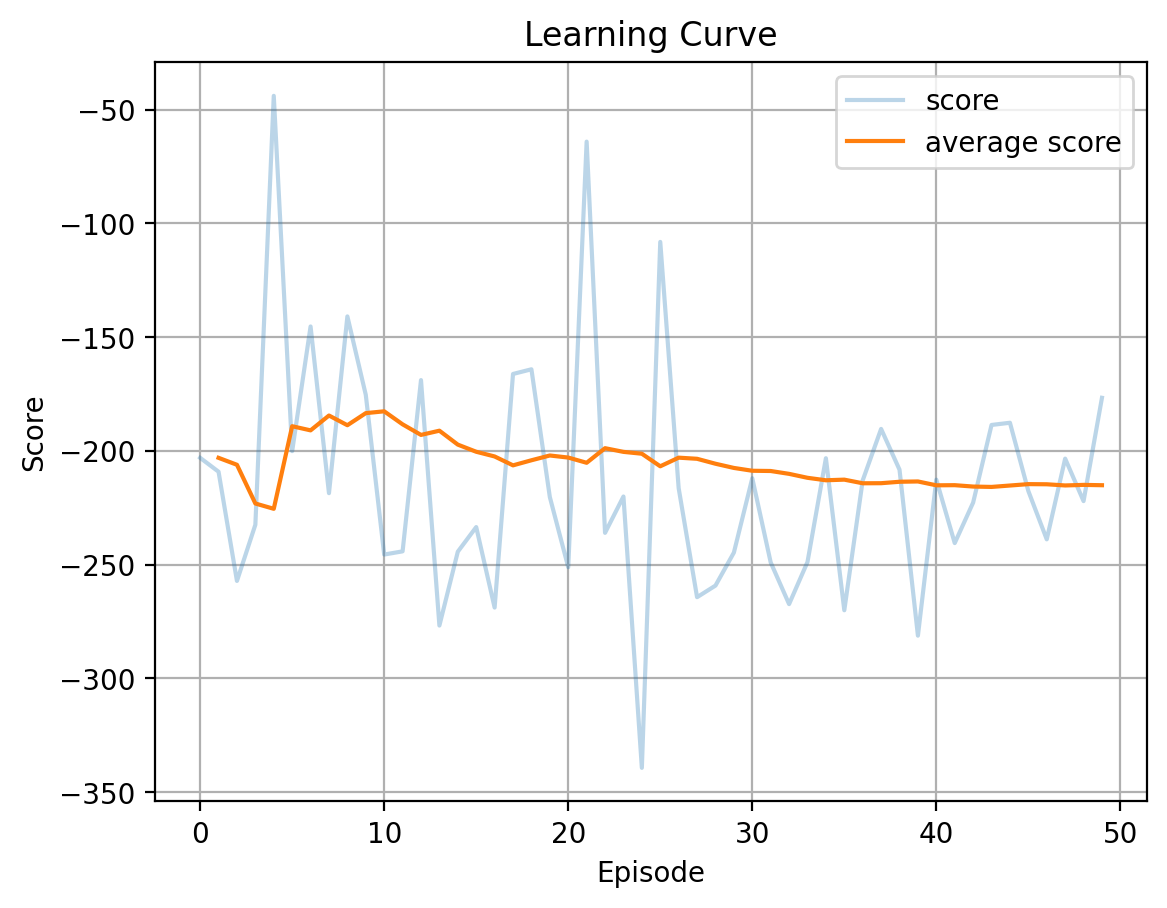

In [92]:
env = gym.make(env_name, render_mode='rgb_array')
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)
if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)

# Initialize agent
agent = Agent(gamma, alpha, beta, 17, env.action_space.shape[0],
              env.action_space.high, fc1_dim, fc2_dim, memory_size, batch_size,
              tau, update_period, reward_scale, warmup, reparam_noise_lim, "yooz")

# Initialize performance tracking variables
scores = []
best_score = -float('inf')
avg_score = 0
score = 0

for game in trange(n_games):
    # Reset environment and initialize variables at the start of each episode
    state, _ = env.reset()
    done = False
    score = 0

    # Interact with the environment until the episode is done
    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.learn()
        state = next_state
        score += reward

    # Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:])  # Average over the last 100 episodes
    best_score = max(best_score, score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')

    # Save the model if the current avg score is better than the best so far
    if avg_score > best_score:
        agent.save(os.path.join(dir_path, f'model_{env_name}'))

env.close()
plot_learning_curve(scores, agent.full_path)


## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [88]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)